# Data

In [1]:
from utils import *
config = load_config("config.yaml")

# read data source
df = pd.read_csv(config['data_path'])
data = pick_from_list_str(df, config['output_cols'], index=config['segment'])

# convert all string to float
data = convert_strings_to_float(data)

# to log scale
data = log_scale_df(data, config['log_cols'])

# remove outliers (thresholding percentile)
# data = add_valid_flag(data, config['longtail_cols'], config['outlier_threshold'])
# data = data[data['valid'] == 1].drop(columns=['valid']).reset_index(drop=True)

# normalized range
data = normalize_min_max(data)
data

,mean_x,mean_y,sigma_x,sigma_y,emittance_x,emittance_y,transmission,klne.zqmd.0208,klne.zqmf.0209,klne.zqmd.0214,klne.zqmf.0215
0,0.788477,0.530907,1.000000,0.020799,1.000000,0.257619,0.850309,0.0,0.0,0.0,0.0
1,0.710011,0.533303,0.974789,0.010109,0.991692,0.211019,0.888669,0.0,0.0,0.0,0.1
2,0.658666,0.536753,0.928535,0.027253,0.977697,0.297091,0.937314,0.0,0.0,0.0,0.2
3,0.621333,0.539016,0.823964,0.050732,0.954580,0.370714,0.978204,0.0,0.0,0.0,0.3
4,0.680710,0.527020,0.645524,0.078637,0.894228,0.414992,0.998299,0.0,0.0,0.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...
14636,0.602963,0.558957,0.146112,0.952870,0.427407,0.748595,0.411552,1.0,1.0,1.0,0.6
14637,0.612399,0.911240,0.137825,0.968324,0.412939,0.747879,0.285939,1.0,1.0,1.0,0.7
14638,0.647749,0.389005,0.130876,0.937929,0.400150,0.739845,0.170585,1.0,1.0,1.0,0.8
14639,0.647844,0.281590,0.129001,0.947957,0.387513,0.742203,0.091376,1.0,1.0,1.0,0.9


# Training

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
config = load_config("config.yaml")

# ——— Model ———
def build_model(config):
    inp = tf.keras.Input(shape=(len(config['input_cols']),))
    
    x = tf.keras.layers.Dense(256, use_bias=False)(inp)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Dense(256, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(128, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(32, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    # linear output for full-range regression
    out = tf.keras.layers.Dense(len(config['target_cols']))(x)
    
    opt = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    model = tf.keras.Model(inp, out)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(),
        # loss='mse',
        metrics=['mae']
    )
    return model

model = build_model(config)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65536     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

Epoch 1/100


2025-07-17 11:27:26.179245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.


367/367 [==============================] - 10s 23ms/step - loss: 0.0436 - mae: 0.2183 - val_loss: 0.0705 - val_mae: 0.3117
Epoch 2/100
367/367 [==============================] - 7s 20ms/step - loss: 0.0161 - mae: 0.1404 - val_loss: 0.0067 - val_mae: 0.0911
Epoch 3/100
367/367 [==============================] - 7s 18ms/step - loss: 0.0122 - mae: 0.1220 - val_loss: 0.0055 - val_mae: 0.0807
Epoch 4/100
367/367 [==============================] - 7s 19ms/step - loss: 0.0103 - mae: 0.1117 - val_loss: 0.0049 - val_mae: 0.0754
Epoch 5/100
367/367 [==============================] - 7s 20ms/step - loss: 0.0091 - mae: 0.1050 - val_loss: 0.0044 - val_mae: 0.0716
Epoch 6/100
367/367 [==============================] - 7s 18ms/step - loss: 0.0083 - mae: 0.1000 - val_loss: 0.0042 - val_mae: 0.0699
Epoch 7/100
367/367 [==============================] - 7s 19ms/step - loss: 0.0077 - mae: 0.0960 - val_loss: 0.0040 - val_mae: 0.0679
Epoch 8/100
367/367 [==============================] - 7s 19ms/step - los

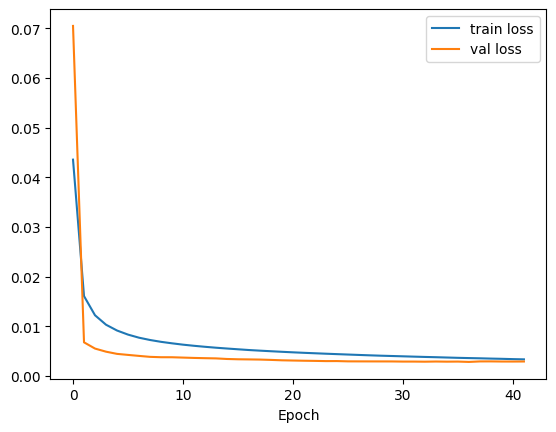

46/46 [==============================] - 0s 5ms/step


In [3]:
# ——— Data prep ———
X = data[config['input_cols']].to_numpy(dtype='float32')
y = data[config['target_cols']].to_numpy(dtype='float32')

n = X.shape[0]
idx = tf.random.shuffle(tf.range(n), seed=config['seed'])
n_test = int(config['test_size'] * n)
n_val  = int(config['val_size']  * n)

test_idx  = idx[:n_test]
val_idx   = idx[n_test:n_test+n_val]
train_idx = idx[n_test+n_val:]

def make_ds(indices):
    return (tf.data.Dataset
              .from_tensor_slices((tf.gather(X, indices),
                                   tf.gather(y, indices)))
              .batch(config['batch_size'])
              .prefetch(tf.data.AUTOTUNE))

train_ds, val_ds, test_ds = map(make_ds, (train_idx, val_idx, test_idx))


# ——— Callbacks ———
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config['patience'],
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=config['model_path'],
        monitor='val_loss',
        save_best_only=True
    )
]

# ——— Train ———
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['epochs'],
    callbacks=callbacks,
    verbose=1
)
model.save(config['model_path'])
plot_history(history)

# ——— Eval ———
X_test = np.vstack([x for x, _ in test_ds])
y_test = np.vstack([y for _, y in test_ds])

# model predictions
y_pred = model.predict(test_ds)

# build and save dataframe
df_out = pd.DataFrame(
    np.hstack([X_test, y_test, y_pred]),
    columns=(
        config['input_cols']
      + [f"true_{c}" for c in config['target_cols']]
      + [f"pred_{c}" for c in config['target_cols']]
    )
)
df_out.to_csv(config['save_to'] + "test_results.csv", index=False)

# Evaluation

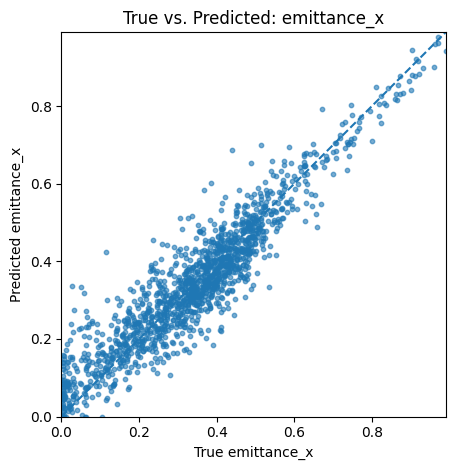

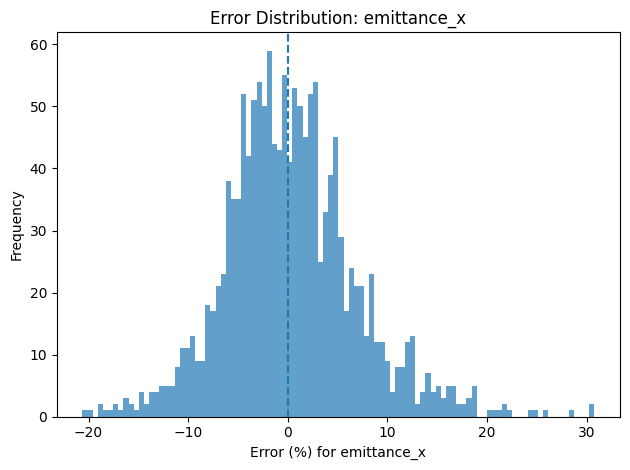

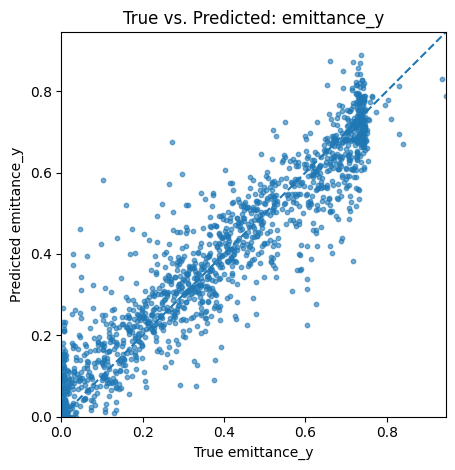

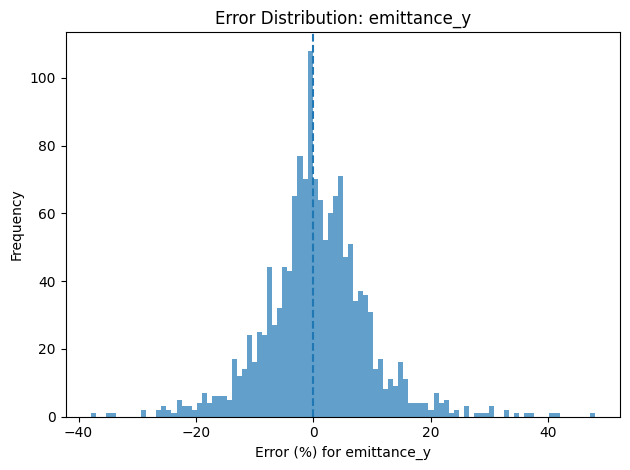

In [4]:
from utils import *
config = load_config("config.yaml")

result = pd.read_csv(config['save_to']+"test_results.csv")
result = clip_df(result)
process_df(result, inputs=config['input_cols'], outputs=config['target_cols'], save_to=config['save_to'])

# Exploratory data analysis

In [ ]:
plot_distributions(data, bins=200)

In [ ]:
from utils import *

config = load_config("config.yaml")


temp = []
for i in range(8):
    df = pd.read_csv(config['data_path'])
    data = pick_from_list_str(df, config['output_cols'], index=i)
    data = convert_strings_to_float(data)
    temp.append(data)
min_d, max_d = compute_bounds(temp)

temp = []
for i in range(8):
    df = pd.read_csv(config['data_path'])
    data = pick_from_list_str(df, config['output_cols'], index=i)
    data = convert_strings_to_float(data)
    temp.append(plot_distributions(data, bins=200, min_bounds=min_d, max_bounds=max_d, title=f'segment_{i+1}'))

figures_to_gif(temp, config['save_to'])